In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-04-10 16:26:40--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.005s  

2022-04-10 16:26:41 (12.0 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



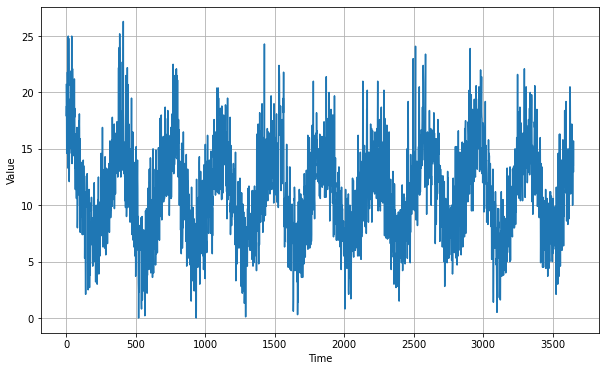

In [8]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for i,row in enumerate(reader):
    time_step.append(i+1)
    temps.append(float(row[1]))
series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [9]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    print("1", series)
    ds = tf.data.Dataset.from_tensor_slices(series)
    print("2", ds)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    print("3", ds)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    print("4", ds)
    ds = ds.shuffle(shuffle_buffer)
    print("5", ds)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    print("6", ds)
    print("7", ds.batch(batch_size).prefetch(1))
    return ds.batch(batch_size).prefetch(1)

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    print("1", ds)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    print("2", ds)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    print("3", ds)
    ds = ds.batch(32).prefetch(1)
    print("4", ds)
    forecast = model.predict(ds)
    print("5", ds)
    return forecast

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


1 tf.Tensor(
[[20.7]
 [17.9]
 [18.8]
 ...
 [ 9.6]
 [10.8]
 [12.1]], shape=(2500, 1), dtype=float64)
2 <TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float64, name=None)>
3 <WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
4 <FlatMapDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
5 <ShuffleDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
6 <MapDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
7 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)
Epoch 1/100
10/10 [===========================

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
print(history.history['lr'][np.argmin(history.history['loss'])])

KeyError: ignored

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

1 tf.Tensor(
[[20.7]
 [17.9]
 [18.8]
 ...
 [ 9.6]
 [10.8]
 [12.1]], shape=(2500, 1), dtype=float64)
2 <TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float64, name=None)>
3 <WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
4 <FlatMapDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
5 <ShuffleDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
6 <MapDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
7 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
Epoch 1/30
25/25 [==============================] - 5s 37ms/step - loss: 9.9814 - mae: 10.4694
Epoch 2/30
25/25 [==============================] - 1s 37ms/step - loss: 2.5295 - mae: 2.9923
Epoch 3/30
25/25 [=======

In [16]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

1 <TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float64, name=None)>
2 <WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
3 <FlatMapDataset element_spec=TensorSpec(shape=(None, 1), dtype=tf.float64, name=None)>
4 <PrefetchDataset element_spec=TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None)>
5 <PrefetchDataset element_spec=TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None)>


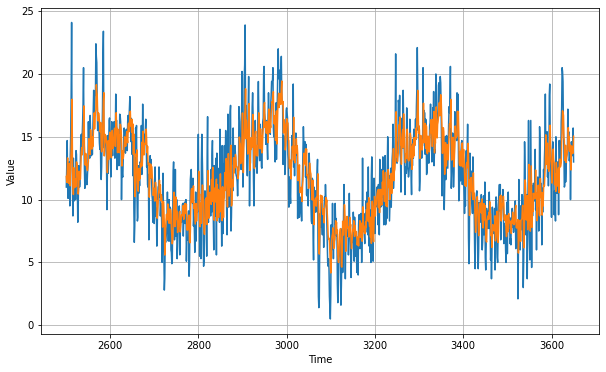

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [18]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8087082

In [19]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.834846 11.37579  12.120975 ... 13.670278 13.742193 15.043724]
